In [1]:
from datasets import load_dataset
import openai
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

c:\Users\gonzalo.arguedas\Project\TFG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('ai2_arc', 'ARC-Challenge')

AI2 Reasoning Challenge (ARC): Contiene preguntas de opción múltiple diseñadas para ser un desafío para los sistemas de IA, ya que requieren razonamiento complejo más allá de la simple recuperación de información.

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 1119
    })
    test: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 1172
    })
    validation: Dataset({
        features: ['id', 'question', 'choices', 'answerKey'],
        num_rows: 299
    })
})


Accedemos a una muestra del dataset

In [3]:
sample = dataset['train'][0]
print("Pregunta:", sample['question'])
print("Opciones:", sample['choices']['text'])
print("Respuesta Correcta:", sample['choices']['text'][sample['choices']['label'].index(sample['answerKey'])])

Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Opciones: ['dry palms', 'wet palms', 'palms covered with oil', 'palms covered with lotion']
Respuesta Correcta: dry palms


In [5]:
dataset.shape

{'train': (1119, 4), 'test': (1172, 4), 'validation': (299, 4)}

In [4]:
train_sample = dataset['train'].select(range(100))  
test_set = dataset['test'] 

Convertimso el dataset en un DataFrame de pandas para una exploracion mas facil

Cargamos la API Key para poder trabajar con los LLMs de OpenAI

In [5]:
load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')
print("API Key cargada correctamente.")
client = OpenAI(api_key=api_key)

API Key cargada correctamente.


### **GPT-3.5-turbo**

In [6]:
def generar_respuesta(modelo, pregunta, opciones, tecnica=None):
    """Genera respuestas utilizando un modelo y una técnica opcional."""
    prompt = f"Pregunta: {pregunta}\nOpciones: {', '.join(opciones)}"
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}]
    if tecnica:
        prompt_tecnica = f"\n{tecnica} Now, refine or expand on the initial answer:"
        messages.append({"role": "system", "content": prompt_tecnica})
    temperatura = 0.7 if tecnica else 0.5

    completion = client.chat.completions.create(
        model=modelo,
        messages=messages,
        temperature=temperatura
    )
    return completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated."


In [14]:
def evaluar_respuestas(dataset, modelo):
    """Evalúa las respuestas generadas y verifica si son correctas comparándolas con la respuesta correcta."""
    resultados = []
    for item in dataset:
        pregunta = item['question']
        opciones = item['choices']['text']
        indice_correcto = item['choices']['label'].index(item['answerKey'])
        respuesta_correcta = opciones[indice_correcto]
        
        respuesta_generada = generar_respuesta(modelo, pregunta, opciones)
        es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
        
        resultados.append({
            'Pregunta': pregunta,
            'Respuesta Generada': respuesta_generada,
            'Respuesta Correcta': respuesta_correcta,
            'Es Correcta': es_correcta
        })
        
        print(f"Pregunta: {pregunta}")
        print(f"Respuesta Generada: {respuesta_generada}")
        print(f"Respuesta Correcta: {respuesta_correcta}")
        print(f"Correcta: {'Sí' if es_correcta else 'No'}")
        print("\n")

    return resultados

In [10]:
resultados_iniciales = evaluar_respuestas(train_sample, "gpt-3.5-turbo")

Pregunta: George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
Respuesta Generada: The skin surface that will produce the most heat when rubbing hands together is palms covered with lotion.
Respuesta Correcta: dry palms
Correcta: No


Pregunta: Which of the following statements best explains why magnets usually stick to a refrigerator door?
Respuesta Generada: The correct answer is: The refrigerator door contains iron.
Respuesta Correcta: The refrigerator door contains iron.
Correcta: No


Pregunta: A fold observed in layers of sedimentary rock most likely resulted from the
Respuesta Generada: The correct answer is: deposition of river sediments.
Respuesta Correcta: converging of crustal plates.
Correcta: No


Pregunta: Which of these do scientists offer as the most recent explanation as to why many plants and animals died out at the end of the Mesozoic era?
Respuesta Generada: The most recent explanation offered by scientists as to why

In [7]:
def evaluar_tecnicas(dataset, modelo, tecnicas):
    resultados = {abr: [] for abr in tecnicas.values()}

    for item in dataset:
        pregunta = item['question']
        opciones = item['choices']['text']
        indice_correcto = item['choices']['label'].index(item['answerKey'])
        respuesta_correcta = opciones[indice_correcto]

        for tecnica, abr in tecnicas.items():
            respuesta_generada = generar_respuesta(modelo, pregunta, opciones, tecnica)
            es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
            resultados[abr].append(es_correcta)

    return resultados

Aplicamos diferentes tecnicas para ver si mejora la precision de las respuestas

In [11]:
tecnicas = {
    None: "Std",  # Standard, sin técnica
    "Think step by step.": "CoT",  # Chain of Thought
    "Provide multiple reasoned answers and select the best one.": "CoT-SC",  # CoT with Self-Consistency
    "Imagine different experts providing step-by-step thoughts.": "ToT",  # Tree of Thoughts
    "Provide detailed context and check sources.": "TCP",  # Tagged Context Prompts
    "Consider your answer carefully and check it before finalizing.": "Auto",  # Autocorrection
    "Combine insights from multiple viewpoints to find the correct answer.": "MA"  # Multiple Agents
}


In [12]:
resultados = evaluar_tecnicas(train_sample, "gpt-3.5-turbo", tecnicas)

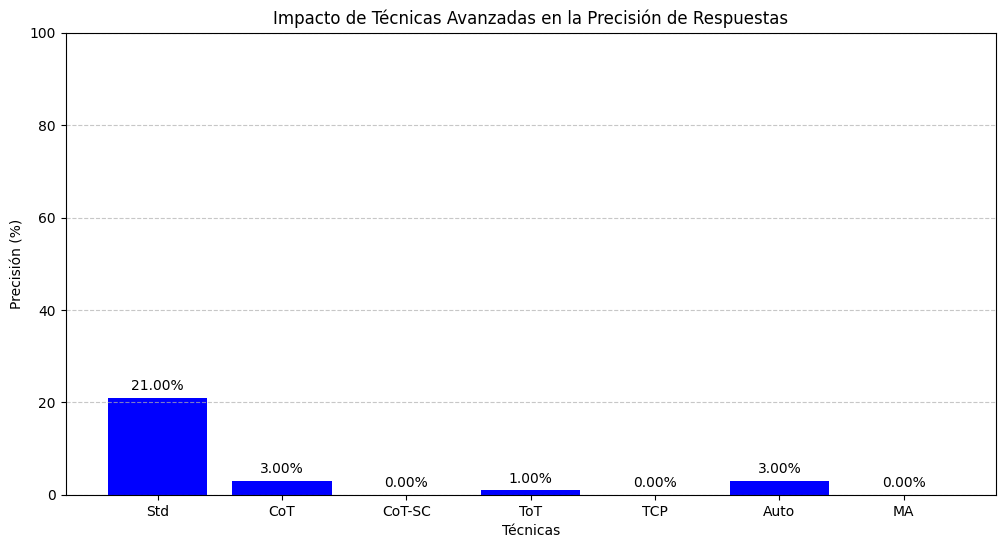

In [13]:
precisiones = {abr: sum(resultados[abr])/len(resultados[abr]) * 100 for abr in resultados}

# Graficar los resultados
plt.figure(figsize=(12, 6))
bars = plt.bar(precisiones.keys(), precisiones.values(), color='blue')
plt.xlabel('Técnicas')
plt.ylabel('Precisión (%)')
plt.title('Impacto de Técnicas Avanzadas en la Precisión de Respuestas')
plt.ylim([0, 100])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de texto con los valores de precisión sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

A continuación, procedemos a variar las temperaturas, con el fin de obtener mejores precisiones

In [6]:
def generar_respuesta(modelo, pregunta, opciones, tecnica=None, temperatura=0.5):
    """Genera respuestas utilizando un modelo, una técnica opcional y temperatura especificada."""
    prompt = f"Pregunta: {pregunta}\nOpciones: {', '.join(opciones)}"
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}]
    if tecnica:
        prompt_tecnica = f"\n{tecnica} Now, refine or expand on the initial answer:"
        messages.append({"role": "system", "content": prompt_tecnica})

    completion = client.chat.completions.create(
        model=modelo,
        messages=messages,
        temperature=temperatura
    )
    return completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated."

In [7]:
def evaluar_tecnicas_por_temperatura(dataset, modelo, tecnicas, temperaturas):
    resultados_por_temp = {temp: {abr: [] for abr in tecnicas.values()} for temp in temperaturas}

    for temp in temperaturas:
        for item in dataset:
            pregunta = item['question']
            opciones = item['choices']['text']
            indice_correcto = item['choices']['label'].index(item['answerKey'])
            respuesta_correcta = opciones[indice_correcto]

            for tecnica, abr in tecnicas.items():
                respuesta_generada = generar_respuesta(modelo, pregunta, opciones, tecnica, temperatura=temp)
                es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
                resultados_por_temp[temp][abr].append(es_correcta)

    return resultados_por_temp


In [8]:
temperaturas = [0.7, 0.4, 0.2]

In [10]:
resultados = evaluar_tecnicas_por_temperatura(train_sample, "gpt-3.5-turbo", tecnicas, temperaturas)

NameError: name 'tecnicas' is not defined

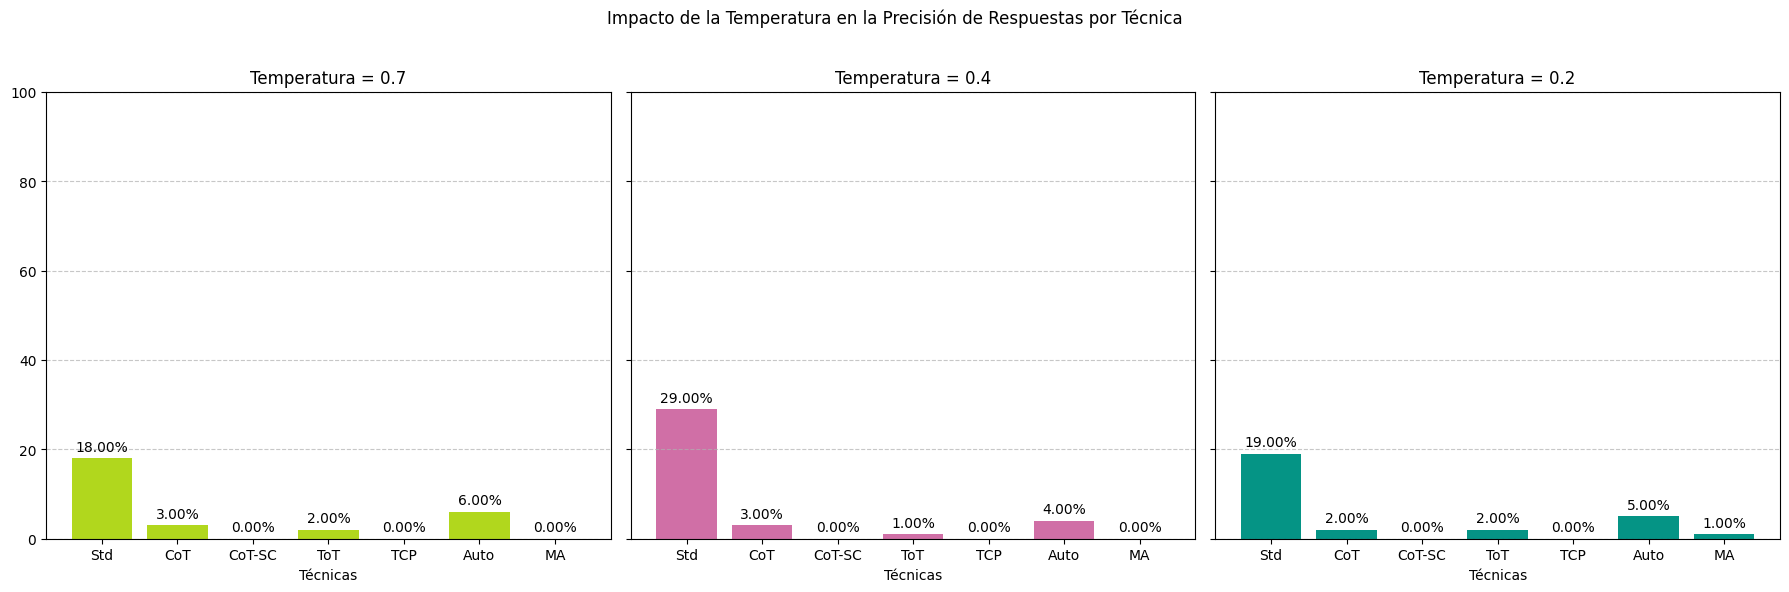

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
fig.suptitle('Impacto de la Temperatura en la Precisión de Respuestas por Técnica')

for ax, temp in zip(axes, temperaturas):
    precisiones = {abr: np.mean(resultados[temp][abr]) * 100 for abr in tecnicas.values()}
    bars = ax.bar(precisiones.keys(), precisiones.values(), color=np.random.rand(3,))
    ax.set_title(f'Temperatura = {temp}')
    ax.set_xlabel('Técnicas')
    ax.set_ylabel('Precisión (%)') if temp == 0.9 else None
    ax.set_ylim([0, 100])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
def generar_respuesta(modelo, pregunta, opciones, tecnica=None):
    """Genera respuestas utilizando un modelo y una técnica opcional."""
    context = f"Pregunta: {pregunta}\nOpciones: {', '.join(opciones)}"
    messages = [{"role": "system", "content": context}, {"role": "user", "content": "What is the correct answer?"}]
    if tecnica:
        messages.append({"role": "system", "content": tecnica})
    temperatura = 0.7 if tecnica else 0.5
    
    completion = client.chat.completions.create(
        model=modelo,
        messages=messages,
        temperature=temperatura
    )
    return completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated."


In [11]:
tecnicas = {
    None: "Std",  # Standard, sin técnica
    "Think step by step.": "CoT",  # Chain of Thought
    "Provide multiple reasoned answers and select the best one.": "CoT-SC",  # CoT with Self-Consistency
    "Imagine different experts providing step-by-step thoughts.": "ToT",  # Tree of Thoughts
    "Provide detailed context and check sources.": "TCP",  # Tagged Context Prompts
    "Consider your answer carefully and check it before finalizing.": "Auto",  # Autocorrection
    "Combine insights from multiple viewpoints to find the correct answer.": "MA"  # Multiple Agents
}


In [12]:
def evaluar_tecnicas(dataset, modelo, tecnicas):
    resultados = {abr: [] for abr in tecnicas.values()}

    for item in dataset:
        pregunta = item['question']
        opciones = item['choices']['text']
        indice_correcto = item['choices']['label'].index(item['answerKey'])
        respuesta_correcta = opciones[indice_correcto]

        for tecnica, abr in tecnicas.items():
            respuesta_generada = generar_respuesta(modelo, pregunta, opciones, tecnica)
            es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
            resultados[abr].append(es_correcta)

    return resultados


In [13]:
resultados = evaluar_tecnicas(dataset['train'].select(range(100)), "gpt-3.5-turbo", tecnicas)

# Calcular la precisión para cada técnica
precisiones = {abr: sum(resultados[abr])/len(resultados[abr]) * 100 for abr in resultados}

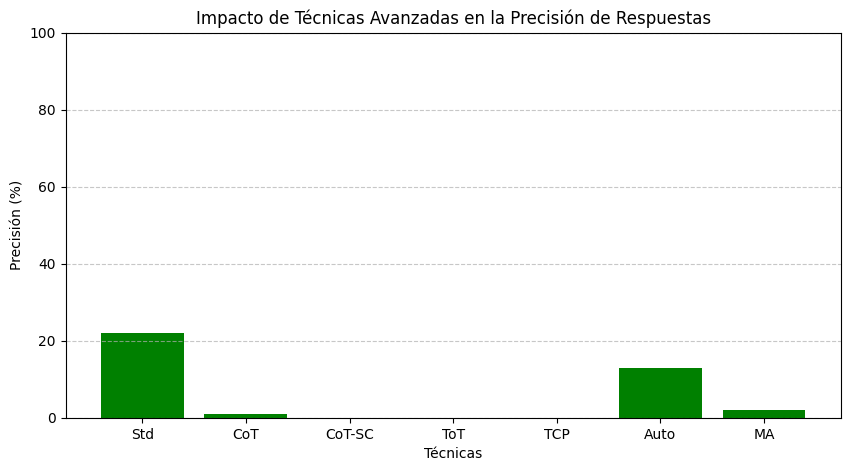

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(precisiones.keys(), precisiones.values(), color='green')
plt.xlabel('Técnicas')
plt.ylabel('Precisión (%)')
plt.title('Impacto de Técnicas Avanzadas en la Precisión de Respuestas')
plt.ylim([0, 100])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **GPT-4**

In [12]:
def generar_respuesta(modelo, pregunta, opciones, tecnica=None):
    """Genera respuestas utilizando un modelo y una técnica opcional."""
    prompt = f"Pregunta: {pregunta}\nOpciones: {', '.join(opciones)}"
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}]
    if tecnica:
        messages.append({"role": "system", "content": tecnica})
    temperatura = 0.7 if tecnica else 0.5
    
    completion = client.chat.completions.create(
        model=modelo,
        messages=messages,
        temperature=temperatura
    )
    return completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated."

def evaluar_tecnicas(dataset, modelo, tecnicas):
    resultados = {abr: [] for abr in tecnicas.values()}

    for item in dataset:
        pregunta = item['question']
        opciones = item['choices']['text']
        indice_correcto = item['choices']['label'].index(item['answerKey'])
        respuesta_correcta = opciones[indice_correcto]

        for tecnica, abr in tecnicas.items():
            respuesta_generada = generar_respuesta(modelo, pregunta, opciones, tecnica)
            es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
            resultados[abr].append(es_correcta)

    return resultados


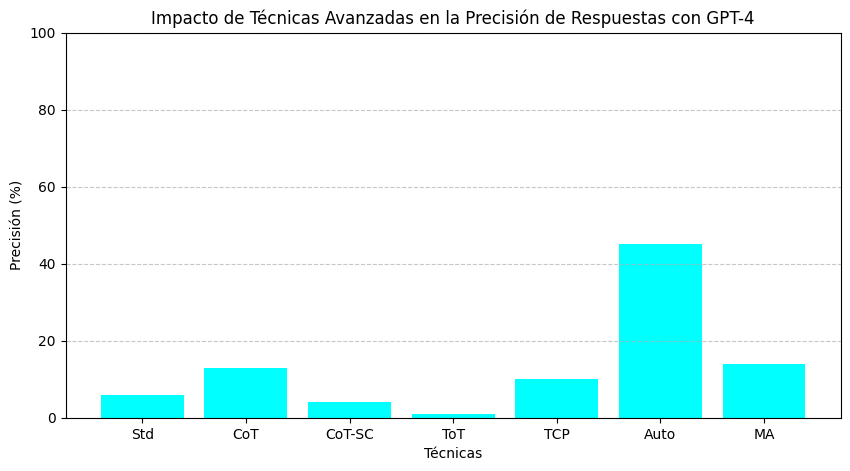

In [14]:
    dataset = load_dataset('ai2_arc', 'ARC-Challenge')['train'].select(range(100))

    model_name = "gpt-4"  # Asegúrate de que este es el identificador correcto para GPT-4
    resultados = evaluar_tecnicas(dataset, model_name, tecnicas)

    # Calcular la precisión para cada técnica
    precisiones = {abr: sum(resultados[abr])/len(resultados[abr]) * 100 for abr in resultados}

    # Graficar los resultados
    plt.figure(figsize=(10, 5))
    plt.bar(precisiones.keys(), precisiones.values(), color='cyan')
    plt.xlabel('Técnicas')
    plt.ylabel('Precisión (%)')
    plt.title('Impacto de Técnicas Avanzadas en la Precisión de Respuestas con GPT-4')
    plt.ylim([0, 100])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.show()

In [15]:
def generar_respuesta(modelo, pregunta, opciones, tecnica=None, temperatura=0.5):
    """Genera respuestas utilizando un modelo y una técnica opcional con temperatura especificada."""
    prompt = f"Pregunta: {pregunta}\nOpciones: {', '.join(opciones)}"
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": "What is the correct answer?"}]
    if tecnica:
        prompt_tecnica = f"\n{tecnica} Now, refine or expand on the initial answer:"
        messages.append({"role": "system", "content": prompt_tecnica})

    completion = client.chat.completions.create(
        model=modelo,
        messages=messages,
        temperature=temperatura
    )
    return completion.choices[0].message.content if completion.choices and completion.choices[0].message else "No response generated."

In [16]:
temperaturas = [0.4, 0.2]

In [17]:
def evaluar_tecnicas_por_temperatura(dataset, modelo, tecnicas, temperaturas):
    resultados_por_temp = {temp: {abr: [] for abr in tecnicas.values()} for temp in temperaturas}

    for temp in temperaturas:
        for item in dataset:
            pregunta = item['question']
            opciones = item['choices']['text']
            indice_correcto = item['choices']['label'].index(item['answerKey'])
            respuesta_correcta = opciones[indice_correcto]

            for tecnica, abr in tecnicas.items():
                respuesta_generada = generar_respuesta(modelo, pregunta, opciones, tecnica, temperatura=temp)
                es_correcta = respuesta_generada.strip().lower() == respuesta_correcta.strip().lower()
                resultados_por_temp[temp][abr].append(es_correcta)

    return resultados_por_temp

In [ ]:
dataset = load_dataset('ai2_arc', 'ARC-Challenge')['train'].select(range(100))

# Evaluar respuestas para cada temperatura
resultados = evaluar_tecnicas_por_temperatura(dataset, "gpt-4", tecnicas, temperaturas)

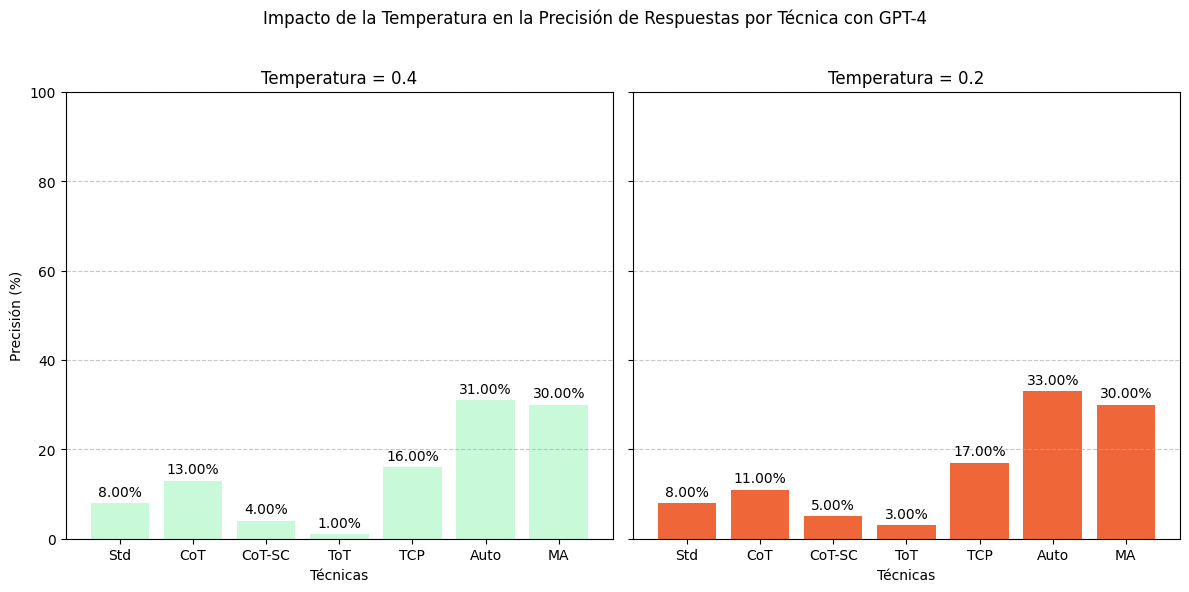

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle('Impacto de la Temperatura en la Precisión de Respuestas por Técnica con GPT-4')

for ax, temp in zip(axes, temperaturas):
    precisiones = {abr: np.mean(resultados[temp][abr]) * 100 for abr in tecnicas.values()}
    bars = ax.bar(precisiones.keys(), precisiones.values(), color=np.random.rand(3,))
    ax.set_title(f'Temperatura = {temp}')
    ax.set_xlabel('Técnicas')
    ax.set_ylabel('Precisión (%)') if temp == 0.4 else None
    ax.set_ylim([0, 100])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()